In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.metrics import *

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

from funciones_OD import *

ruta = "G:/PhD/Datos SIATA/Análisis/Descriptivo/"
archivo = "DF"
datos = pd.read_csv(ruta+"set_datos_df/set_test_outliers.csv",sep=",")
entreno = pd.read_csv(ruta+"set_datos_df/set_entrenamiento.csv",sep=",")
sensor = "pm25"
redondeo = 4
variables = ['pm25']#,'humedad_relativa', 'temperatura'
for sensor in variables:
    datos[sensor] = pd.Series([round(val,redondeo) for val in datos[sensor]])
    entreno[sensor] = pd.Series([round(val,redondeo) for val in entreno[sensor]])

Nodo: 50 Faltan: 3
Nodo: 134 Faltan: 2
Nodo: 187 Faltan: 1
Nodo: 266 Faltan: 0
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 1, 32)             256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 16)             3600      
_________________________________________________________________
conv1d_transpose_12 (Conv1DT (None, 2, 16)             1808      
_________________________________________________________________
dropout_9 (Dropout)          (None, 2, 16)             0         
_________________________________________________________________
conv1d_transpose_13 (Conv1DT (None, 4, 32)             3616      
_________________________________________

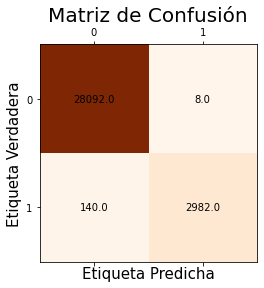

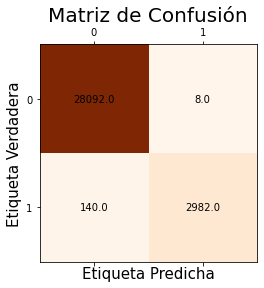

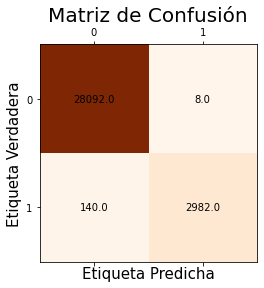

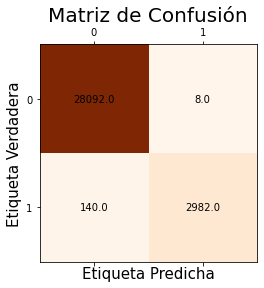

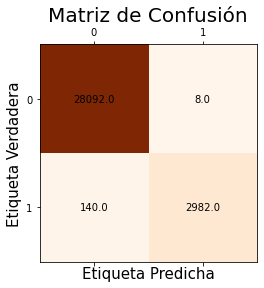

In [28]:
pd.options.mode.chained_assignment = None  # default='warn'

nodos_entreno = entreno.codigoSerial.unique().tolist()
entrenamiento = pd.DataFrame()
prediccion = pd.DataFrame()
Evaluacion_ident_outliers = pd.DataFrame(columns =["Technique","Variable","Precision","Recall","F1","Accuracy","Time"])

for rep in range (5):
    now = datetime.now()
    time_hbos = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)
    time_percentil = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)
    time_autoencoder = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)

    # Beginning to prepare training and test datasets
    for i in nodos_entreno:
        print("Nodo:",i, "Faltan:", len(nodos_entreno)-(nodos_entreno.index(i)+1))
        fild = entreno.loc[entreno.loc[:,"codigoSerial"] == i]
        fild.reset_index(inplace=True, drop=True)
            
        if (len(fild)<=0):
            print("No hay datos del nodo", i)
            continue
            
        diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos

        entrenamiento = pd.concat([entrenamiento,fild],ignore_index=True)

    entrenamiento["fechaHora"] = entrenamiento["fecha"] + " " + entrenamiento["hora"]
    df_small_noise = entrenamiento.loc[:,["fechaHora", variables[0]]]
    df_small_noise.set_index("fechaHora", inplace=True)

    datos["fechaHora"] = datos["fecha"] + " " + datos["hora"]
    df_daily_jumpsup = datos.loc[:,["fechaHora", variables[0]]]
    pd.to_datetime(df_daily_jumpsup["fechaHora"])
    df_daily_jumpsup.set_index("fechaHora", inplace=True)

    # End to prepare training and test datasets 

    # Calculating HBOS Score
    HBOS = {}
    hbos_inicio = datetime.now()

    ks,kd,n,tam_bin,bins = calcula_k(entrenamiento,variables,redondeo) # Calcula los intervalos de forma dinámica y estática y el tamaño del bin para cada uno

    for sensor in variables:
        
        # Asigna los valores a cada intervalo
        intervalos = asigna_ks(entrenamiento[sensor+'_dif'],bins) # Asignación de valores en intervalos de forma estática
        #intervalos = asigna_kd(n,entrenamiento[sensor],kd) # Asignación de valores en intervalos de forma dinpamica
                
        # Cálculo de ponderaciones de acuerdo con la frecuencia de cada intervalo (densidad de cada intervalo)
        ponderaciones = calcula_ponderaciones(intervalos,redondeo)
                
        # Cálculo del scor HBOS para cada valor único.
        HBOS = calcula_HBOS(ponderaciones,HBOS)
        
    hbos_fin = datetime.now()
    time_hbos = time_hbos +(hbos_fin-hbos_inicio)

    # Fin to calculate HBOS score

    # Training Autoencoder

    autoencoder_inicio = datetime.now()
    training_mean = df_small_noise.mean()
    training_std = df_small_noise.std()
    df_training_value = (df_small_noise - training_mean) / training_std

    TIME_STEPS = 1

    # Generated training sequences for use in the model.
    def create_sequences(values, time_steps=TIME_STEPS):
        output = []
        for i in range(len(values) - time_steps + 1):
            output.append(values[i : (i + time_steps)])
        return np.stack(output)


    x_train = create_sequences(df_training_value.values)

    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()
    plot_model(model, to_file='model_plot_convo.png', show_shapes=True, show_layer_names=True)

    history = model.fit(
        x_train,
        x_train,
        verbose=0,
        epochs=50,
        batch_size=128,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
    )
    autoencoder_fin = datetime.now()
    time_autoencoder = time_autoencoder +(autoencoder_fin-autoencoder_inicio)
    # Fin to training autoencoder

    #### OUTLIER IDENTIFICATION ####


    datos2 = datos.copy()
    datos2=datos2.assign(HBOS="N", Percentile="N")
    ident_outliers = pd.DataFrame()
    nodos = datos2.codigoSerial.unique().tolist()
    fechas = datos2.fecha.unique().tolist()

    margen_HBOS = 4.5
    percentil = 90
    margen_percentil = 10

    cont = 0
    for i in nodos:
        fild = datos2.loc[datos2.loc[:,"codigoSerial"] == i]
        fild.reset_index(inplace=True, drop=True)

        diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos

        for j in fechas:
        
            fil = fild.loc[fild.loc[:,"fecha"] == j]
            fil.reset_index(inplace=True, drop=True)

            if (len(fil)<=0):
                continue

            for sensor in variables:
                percen = np.percentile(fil[sensor],[percentil])
                #print(percen)
        
                for k in range(1,len(fil)):
                    cont += 1

    # HBOS Outlier Detection 
                    hbos_inicio = datetime.now()         
                    # Validación de cada valor contra su respectivo score HBOS
                    hbos_inicio = datetime.now()
                    ponde = verifica_HBOS(HBOS,fil[variables[0]+'_dif'][k-1],bins)

                    if  ponde > margen_HBOS:
                        ponde = verifica_HBOS(HBOS,fil[variables[0]+'_dif'][k],bins)
                        if  ponde > margen_HBOS: 
                            fil.loc[k-1,"HBOS"]= "S"         
                                        
                    hbos_fin = datetime.now()
                    time_hbos = time_hbos +(hbos_fin-hbos_inicio)
                    


    # Percentile Outlier Detection
                    percentil_inicio = datetime.now()
                    if (fil[sensor][k] > percen) and ((abs(fil[sensor][k] - fil[sensor][k-1])>margen_percentil) or (fil['Percentile'][k-1] == "S")):
                        fil.loc[k,('Percentile')]= "S"
                    percentil_fin = datetime.now()
                    time_percentil = time_percentil +(percentil_fin-percentil_inicio)
                
            ident_outliers = pd.concat([ident_outliers,fil],ignore_index=True)


            

        
    # Autoencoder Outlier Detection
    autoencoder_inicio = datetime.now()
    x_train_pred = model.predict(x_train)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)

    df_test_value = (df_daily_jumpsup - training_mean) / training_std

    # Create sequences from test values.
    x_test = create_sequences(df_test_value.values)

    # Get test MAE loss.
    x_test_pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

    # Detect all the samples which are anomalies.
    anomalies = test_mae_loss > threshold

    autoencoder_fin = datetime.now()
    time_autoencoder = time_autoencoder +(autoencoder_fin-autoencoder_inicio)




    ######  CONFUSION MATRIX #########

    # Autoencoder
        
    real = datos2.pm25_outlier.tolist()
    real = ['S' if value!='N' else value for value in real]
    predicho = ['S' if value==True else value for value in anomalies]
    predicho = ['N' if value==False else value for value in predicho]

    acc, re, pre, f1 = confu_matrix_no_print (real,predicho)

    Evaluacion_ident_outliers.loc[len(Evaluacion_ident_outliers)]=["Autoencoder", TIME_STEPS, pre, re, f1, acc,time_autoencoder.time()]

    # HBOS
    real = ident_outliers.pm25_outlier.tolist()
    real = ['S' if value!='N' else value for value in real]
    predicho = ident_outliers.HBOS.tolist()

    acc, re, pre, f1 = confu_matrix_no_print (real,predicho)

    Evaluacion_ident_outliers.loc[len(Evaluacion_ident_outliers)]=["HBOS", margen_HBOS, pre, re, f1, acc, time_hbos.time()]

    # Percentil
    real = ident_outliers.pm25_outlier.tolist()
    real = ['S' if value!='N' else value for value in real]
    predicho = ident_outliers.Percentile.tolist()
    confu_matrix (real,predicho)

    acc, re, pre, f1 = confu_matrix_no_print (real,predicho)
    margen = str(percentil)+"/"+str(margen_percentil)

    Evaluacion_ident_outliers.loc[len(Evaluacion_ident_outliers)]=["Percentile", margen, pre, re, f1, acc, time_percentil.time()]

    




In [29]:
Evaluacion_ident_outliers


,Tecnique,Variable,Precision,Recall,F1,Accuracy,Time
0,Autoencoder,1,1.000000,0.969891,0.984715,0.996989,00:00:20.950137
1,HBOS,4.5,0.898269,0.814542,0.854359,0.972231,00:00:02.828281
2,Percentile,90/10,0.997324,0.955157,0.975785,0.995260,00:00:01.685058
3,Autoencoder,1,1.000000,0.969891,0.984715,0.996989,00:00:35.650439
4,HBOS,4.5,0.898269,0.814542,0.854359,0.972231,00:00:03.039063
5,Percentile,90/10,0.997324,0.955157,0.975785,0.995260,00:00:01.809060
6,Autoencoder,1,1.000000,0.969891,0.984715,0.996989,00:01:20.478916
7,HBOS,4.5,0.898269,0.814542,0.854359,0.972231,00:00:03.112018
8,Percentile,90/10,0.997324,0.955157,0.975785,0.995260,00:00:01.638296
9,Autoencoder,1,1.000000,0.969891,0.984715,0.996989,00:01:21.906718
